In [1]:
%env TOKENIZERS_PARALLELISM=false
%env WANDB_DISABLED=true
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from transformers import (
    AutoTokenizer, 
    AutoModel, 
    AdamW, 
    AutoConfig, 
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    AutoModelForSequenceClassification
)

from datasets import Dataset

import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

env: TOKENIZERS_PARALLELISM=false
env: WANDB_DISABLED=true


In [2]:
class args:
    model = 'ProsusAI/finbert'

In [3]:

df = pd.read_csv('/kaggle/input/news-sentiment-analysis/news.csv')

In [4]:
df.rename(columns={'sentiment': 'labels', 'news': 'messages'}, inplace=True)

# Set date as index
df['date'] = pd.to_datetime(df['date'])  # Convert to datetime if necessary
df.set_index('date', inplace=True)

In [5]:
le = LabelEncoder()
df['labels'] = le.fit_transform(df['labels'])
df['labels'].value_counts()

labels
0    217443
1    210039
Name: count, dtype: int64

Now let's split the given data into train, test and validation

We will be using the train data to train the mode, the validation data to determiine the performance of the model and the test data to check how the model performs on unseen data

We will stratify on the `labels` so that the data remains balanced for train, test and validation data

In [6]:
# X, y = df['messages'].values, df['labels'].values

# # train : test = 0.9 : 0.1
# xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, stratify=y)

# # train : valid = 0.8 : 0.2
# xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain, ytrain, test_size=0.2, stratify=ytrain)

# # train : valid : test = 0.72 : 0.18 : 0.10 (stratified on 'labels')

In [7]:
df = df.sort_index()

total_rows = len(df)
train_end = int(total_rows * 0.72)
valid_end = train_end + int(total_rows * 0.18)

train = df.iloc[:train_end]
valid = df.iloc[train_end:valid_end]
test = df.iloc[valid_end:]

In [8]:
# Convert to NumPy arrays
X_train = train.drop(columns=['labels']).to_numpy()  # Features for training
y_train = train['labels'].to_numpy()                # Target labels for training

X_valid = valid.drop(columns=['labels']).to_numpy()  # Features for validation
y_valid = valid['labels'].to_numpy()                 # Target labels for validation

X_test = test.drop(columns=['labels']).to_numpy()    # Features for testing
y_test = test['labels'].to_numpy()

# Dataset

In [9]:
X_train = [str(x) for x in X_train]
X_valid = [str(x) for x in X_valid]
X_test = [str(x) for x in X_test]

In [10]:
train_dataset_raw = Dataset.from_dict({'text':X_train, 'labels':y_train})
valid_dataset_raw = Dataset.from_dict({'text':X_valid, 'labels':y_valid})
pred_dataset_raw = Dataset.from_dict({'text': X_test})
pred_dataset_raw

Dataset({
    features: ['text'],
    num_rows: 42749
})

In [11]:
def tokenize_fn(examples):
    return tokenizer(examples['text'], truncation=True)

In [12]:
tokenizer = AutoTokenizer.from_pretrained(args.model)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [13]:
train_dataset_raw

Dataset({
    features: ['text', 'labels'],
    num_rows: 307787
})

In [14]:
train_dataset = train_dataset_raw.map(tokenize_fn, batched=True)
valid_dataset = valid_dataset_raw.map(tokenize_fn, batched=True)

data_collator = DataCollatorWithPadding(tokenizer)

Map:   0%|          | 0/307787 [00:00<?, ? examples/s]

Map:   0%|          | 0/76946 [00:00<?, ? examples/s]

In [15]:
from torch.nn.init import xavier_uniform_
model = AutoModelForSequenceClassification.from_pretrained(args.model,num_labels=2,ignore_mismatched_sizes=True)


# Reinitialize the classification layer
xavier_uniform_(model.classifier.weight)
model.classifier.bias.data.zero_()

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([0., 0.])

In [16]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=-1)
    return {'accuracy': accuracy_score(labels, preds)}

In [17]:
train_args = TrainingArguments(
    './Finbert Trained/',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=2*16,
    num_train_epochs=5,
    learning_rate=1e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,    
    do_eval=True,
    do_train=True,
    do_predict=True,
    eval_strategy='epoch',
    save_strategy="no",
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [18]:
trainer = Trainer(
    model,
    train_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [19]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.066000,0.072285,0.970070
2,0.051400,0.070103,0.973124
3,0.028600,0.089130,0.974242
4,0.014600,0.128894,0.973072
5,0.009200,0.162156,0.974554


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=48095, training_loss=0.04481345879237188, metrics={'train_runtime': 18528.5769, 'train_samples_per_second': 83.057, 'train_steps_per_second': 2.596, 'total_flos': 6.261622037101669e+16, 'train_loss': 0.04481345879237188, 'epoch': 5.0})

In [20]:
trainer.save_model('finbert_finetuned.bin')

In [21]:
pred_dataset = pred_dataset_raw.map(tokenize_fn, batched=False)

Map:   0%|          | 0/42749 [00:00<?, ? examples/s]

In [22]:
len(pred_dataset[0]['input_ids'])

56

In [23]:
output = trainer.predict(
    test_dataset=pred_dataset,
)

In [24]:
output.predictions

array([[-7.1901965,  7.9286437],
       [-7.146272 ,  8.063237 ],
       [-7.2060237,  7.8526754],
       ...,
       [ 6.8941875, -8.271556 ],
       [-7.138821 ,  8.072662 ],
       [-3.2037811,  4.9615793]], dtype=float32)

In [25]:
preds = [np.argmax(x) for x in output.predictions]

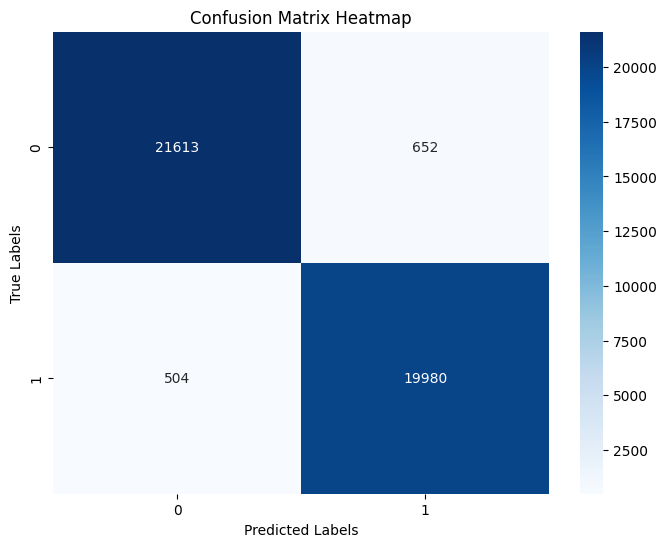

In [26]:

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds)

# Define class labels
labels = [0, 1]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')

# Display the plot
plt.show()

In [27]:
accuracy_score(y_test, preds)

0.9729584317761819

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     22265
           1       0.97      0.98      0.97     20484

    accuracy                           0.97     42749
   macro avg       0.97      0.97      0.97     42749
weighted avg       0.97      0.97      0.97     42749



In [29]:
news = pd.read_csv('/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv',names= ['Sentiment','Sentence'],encoding='ISO-8859-1')

In [30]:
news

,Sentiment,Sentence
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [31]:
x_test, Y_test = news['Sentence'].values, news['Sentiment'].values

In [32]:
le = LabelEncoder()
Y_test = le.fit_transform(Y_test)

In [33]:
np.unique(Y_test)

array([0, 1, 2])

In [34]:
test_dataset_raw = Dataset.from_dict({'text': x_test})
test_dataset_raw

Dataset({
    features: ['text'],
    num_rows: 4846
})

In [35]:
test_dataset = test_dataset_raw.map(tokenize_fn, batched=False)

Map:   0%|          | 0/4846 [00:00<?, ? examples/s]

In [36]:
output = trainer.predict(
    test_dataset=test_dataset,
)

In [37]:
preds = [np.argmax(x) for x in output.predictions]

In [38]:
output.predictions

array([[ 1.1306946, -1.2269255],
       [-2.1537461,  2.4970188],
       [ 4.0509453, -4.716724 ],
       ...,
       [ 4.987737 , -5.526959 ],
       [ 5.814077 , -6.639133 ],
       [ 5.815946 , -6.4994617]], dtype=float32)

In [39]:
np.unique(preds)

array([0, 1])

In [40]:
def transform(x):
    if x == 2:
        return 1
    elif x == 1:
        return 0
    else:  # x == 0
        return 0
        
vectorized_transform = np.vectorize(transform)
Y_test = vectorized_transform(Y_test)

In [41]:
np.unique(Y_test)

array([0, 1])

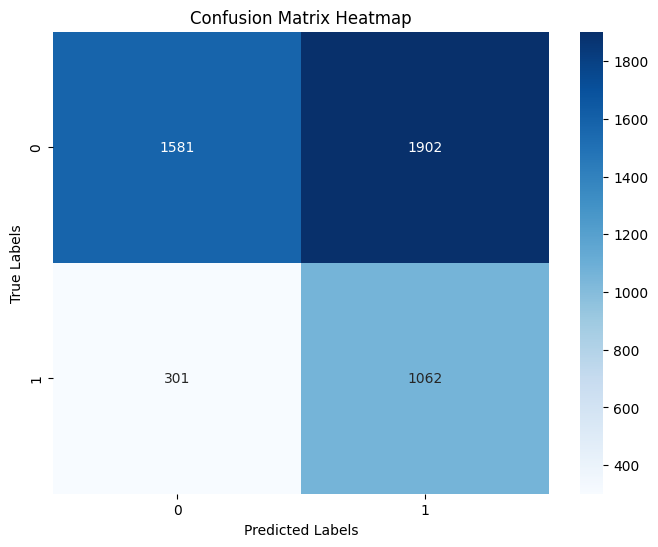

In [42]:
cm = confusion_matrix(Y_test, preds)

# Define class labels
labels = [0, 1]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')

# Display the plot
plt.show()

In [43]:
accuracy_score(Y_test, preds)

0.5453982666116385

In [44]:
print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

           0       0.84      0.45      0.59      3483
           1       0.36      0.78      0.49      1363

    accuracy                           0.55      4846
   macro avg       0.60      0.62      0.54      4846
weighted avg       0.70      0.55      0.56      4846

